In [4]:
#BIBLIOTECAS

import os
from astropy.io import fits
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [5]:
#LER ARQUIVOS

def ler_arquivos_fits(pasta):
    dados = []
    for nome_arquivo in os.listdir(pasta):
        if nome_arquivo.endswith('.fits'):
            caminho_arquivo = os.path.join(pasta, nome_arquivo)
            with fits.open(caminho_arquivo) as hdul:
                dados.append(hdul[0].data)  # Assumindo que os dados estão na primeira extensão
    return np.array(dados)

# Exemplo de uso
pasta = './ima_g'
dados = ler_arquivos_fits(pasta)
print(f"Lidos {len(dados)} arquivos FITS.")

Lidos 4458 arquivos FITS.


In [6]:
#APLICAR PCA
def aplicar_pca(dados, n_componentes=2):
    # Redimensionar os dados para 2D (amostras, características)
    n_amostras, altura, largura = dados.shape
    dados_2d = dados.reshape(n_amostras, -1)
    
    # Aplicar PCA
    pca = PCA(n_components=n_componentes)
    componentes_principais = pca.fit_transform(dados_2d)
    
    return componentes_principais, pca

# Aplicar PCA com 10 componentes principais (para visualização 2D)
n_componentes = 10
componentes_principais, pca = aplicar_pca(dados, n_componentes)
print(f"Shape dos componentes principais: {componentes_principais.shape}")

Shape dos componentes principais: (4458, 10)


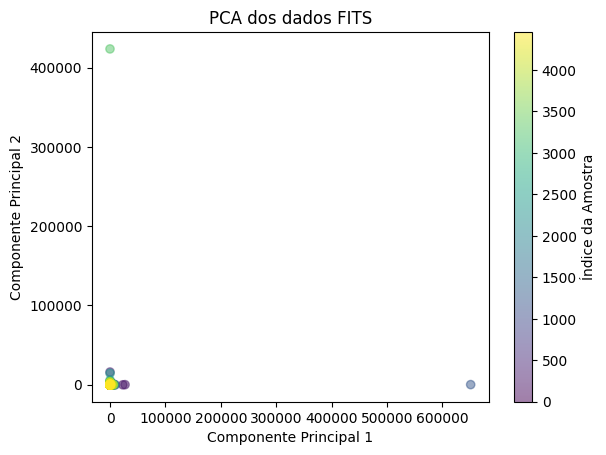

In [7]:
#PLOTAR COMPONENTE PRINCIPAL 1 E 2

plt.scatter(componentes_principais[:, 0], componentes_principais[:, 1], c=np.arange(len(componentes_principais)), cmap='viridis', alpha=0.5)
plt.colorbar(label="Índice da Amostra")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos dados FITS')
plt.show()

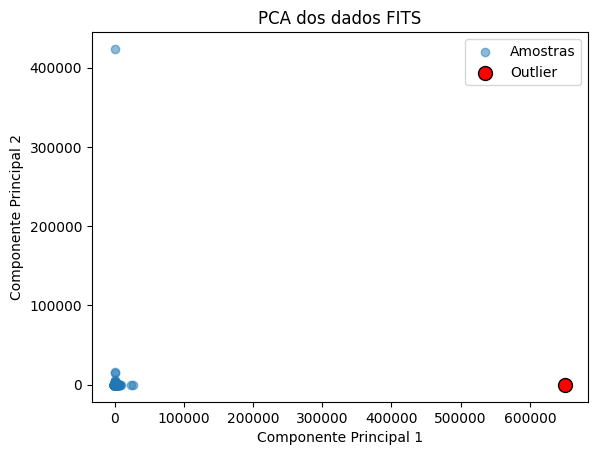

Índice do ponto desconexo: 1207
Nome do arquivo: PGC0057728_g.fits


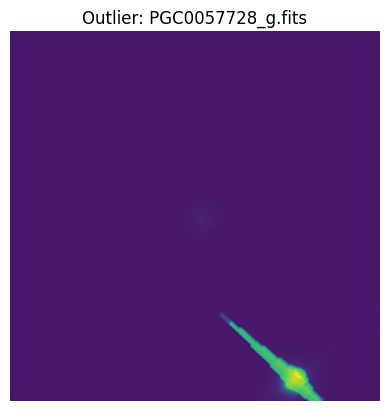

In [8]:

# Calcular a média dos componentes principais
centroide = np.mean(componentes_principais, axis=0)

# Calcular distâncias euclidianas de cada ponto ao centroide
distancias = np.linalg.norm(componentes_principais - centroide, axis=1)

# Identificar o índice do ponto mais distante
indice_outlier = np.argmax(distancias)

# Plotar os dados e destacar o outlier
plt.scatter(componentes_principais[:, 0], componentes_principais[:, 1], alpha=0.5, label="Amostras")
plt.scatter(componentes_principais[indice_outlier, 0], componentes_principais[indice_outlier, 1], 
            color='red', edgecolor='black', s=100, label="Outlier")  # Destacar outlier

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos dados FITS')
plt.legend()
plt.show()

# Exibir nome e imagem do outlier
nomes_arquivos = [nome for nome in os.listdir(pasta) if nome.endswith('.fits')]
print(f"Índice do ponto desconexo: {indice_outlier}")
print(f"Nome do arquivo: {nomes_arquivos[indice_outlier]}")

plt.imshow(dados[indice_outlier], cmap='viridis')
plt.title(f"Outlier: {nomes_arquivos[indice_outlier]}")
plt.axis('off')
plt.show()

In [9]:
# Criar uma máscara para manter todos os índices, exceto o do outlier
mascara = np.arange(len(componentes_principais)) != indice_outlier

# Aplicar a máscara para excluir o outlier
componentes_principais = componentes_principais[mascara]
dados = dados[mascara]
nomes_arquivos = np.array(nomes_arquivos)[mascara]

print(f"Nova amostra sem o outlier: {len(componentes_principais)} elementos.")

Nova amostra sem o outlier: 4457 elementos.


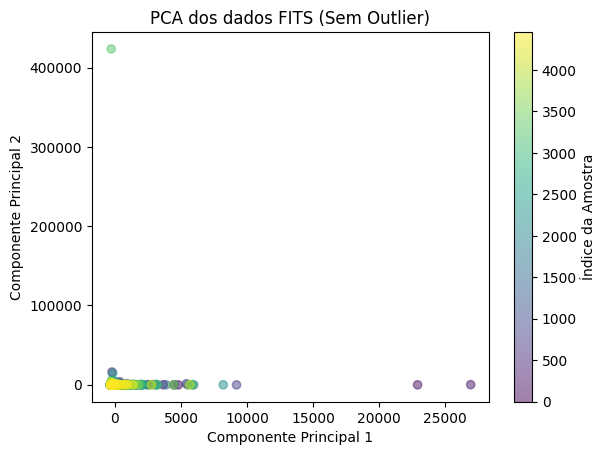

In [10]:
plt.scatter(componentes_principais[:, 0], componentes_principais[:, 1], 
            c=np.arange(len(componentes_principais)), cmap='viridis', alpha=0.5)
plt.colorbar(label="Índice da Amostra")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos dados FITS (Sem Outlier)')
plt.show()

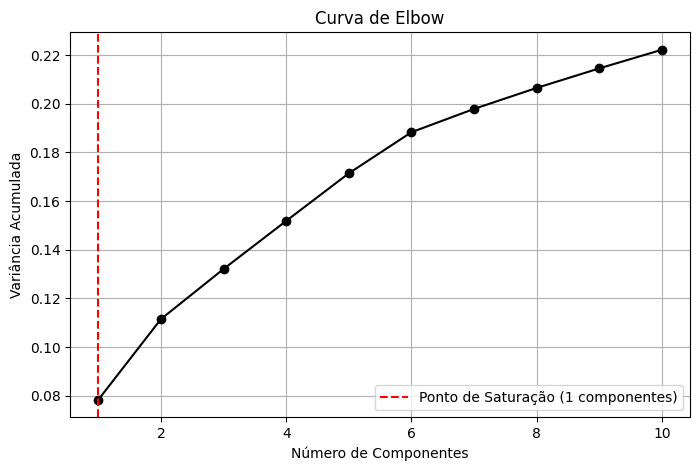

In [11]:
# Variância explicada por cada componente
variancias_explicadas = pca.explained_variance_ratio_

# Variância acumulada
variancia_acumulada = np.cumsum(variancias_explicadas)

# Encontrar o ponto de saturação (cotovelo) - aqui vamos usar 70% como exemplo
threshold = 0.70  # Por exemplo, 70% de variância explicada
ponto_saturacao = np.argmax(variancia_acumulada >= threshold) + 1  # Adiciona 1 porque a indexação começa do 0

# Plotar a Curva de Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, color='black', marker='o', linestyle='-')
plt.axvline(x=ponto_saturacao, color='red', linestyle='--', label=f'Ponto de Saturação ({ponto_saturacao} componentes)')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Curva de Elbow')
plt.legend()
plt.grid(True)
plt.show()

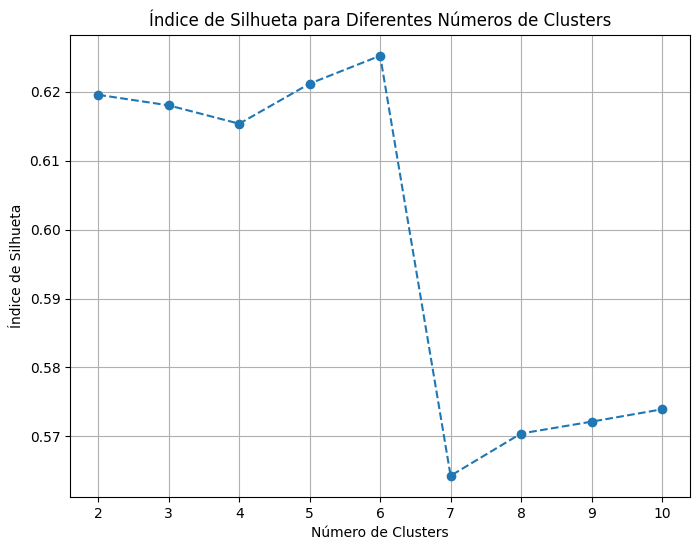

In [12]:

# Testando diferentes números de clusters
scores = []
for k in range(2, 11):  # Começa de 2, pois não faz sentido calcular a silhueta para 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(componentes_principais)
    score = silhouette_score(componentes_principais, kmeans.labels_)
    scores.append(score)

# Plotando o índice de silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), scores, marker='o', linestyle='--')
plt.title('Índice de Silhueta para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silhueta')
plt.grid(True)
plt.show()

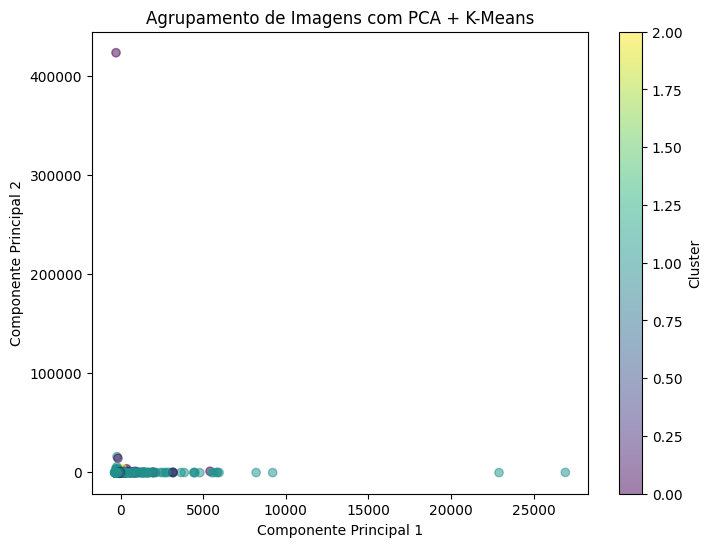

In [13]:
# Agora, aplicar K-Means para agrupar as imagens
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajuste o número de clusters (k) conforme necessário
labels = kmeans.fit_predict(componentes_principais)

# Plotando os clusters no espaço das componentes principais (usando as duas primeiras componentes)
plt.figure(figsize=(8, 6))
plt.scatter(componentes_principais[:, 0], componentes_principais[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title("Agrupamento de Imagens com PCA + K-Means")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

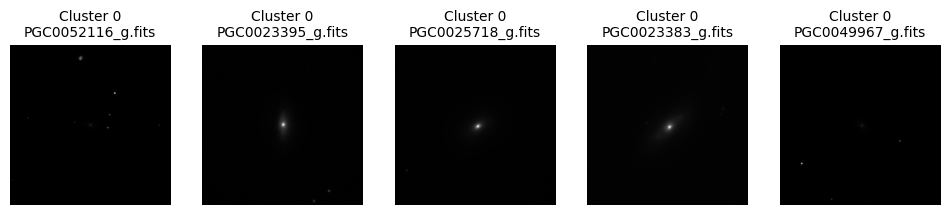

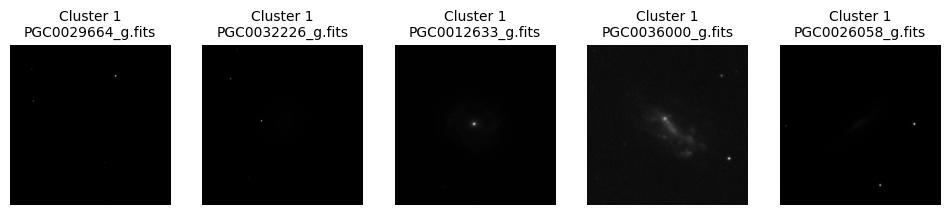

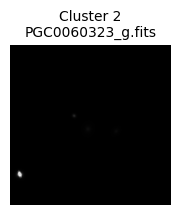

In [14]:
# Plotando as 5 primeiras imagens de cada cluster
for cluster in range(3):  # Ajuste conforme o número de clusters
    plt.figure(figsize=(12, 6))
    cluster_indices = np.where(labels == cluster)[0]
    for i, idx in enumerate(cluster_indices[:5]):  # Mostra as 5 primeiras imagens de cada cluster
        plt.subplot(1, 5, i+1)
        plt.imshow(dados[idx], cmap='gray')  # Utiliza o colormap 'gray'
        plt.title(f"Cluster {cluster}\n{nomes_arquivos[idx]}", fontsize=10)  # Exibe o nome do arquivo
        plt.axis('off')
    plt.show()